In [5]:
import pandas as pd
filename = "stroke-dataset.csv"
data = pd.read_csv(filename)

In [6]:
data 

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,67,Female,17.0,0,0,No,Private,Urban,92.97,NaN,formerly smoked,0
1,77,Female,13.0,0,0,No,children,Rural,85.81,18.6,Unknown,0
2,84,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0
3,91,Female,42.0,0,0,No,Private,Urban,98.53,18.5,never smoked,0
4,99,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
5106,72914,Female,19.0,0,0,No,Private,Urban,90.57,24.2,Unknown,0
5107,72915,Female,45.0,0,0,Yes,Private,Urban,172.33,45.3,formerly smoked,0
5108,72918,Female,53.0,1,0,Yes,Private,Urban,62.55,30.3,Unknown,1


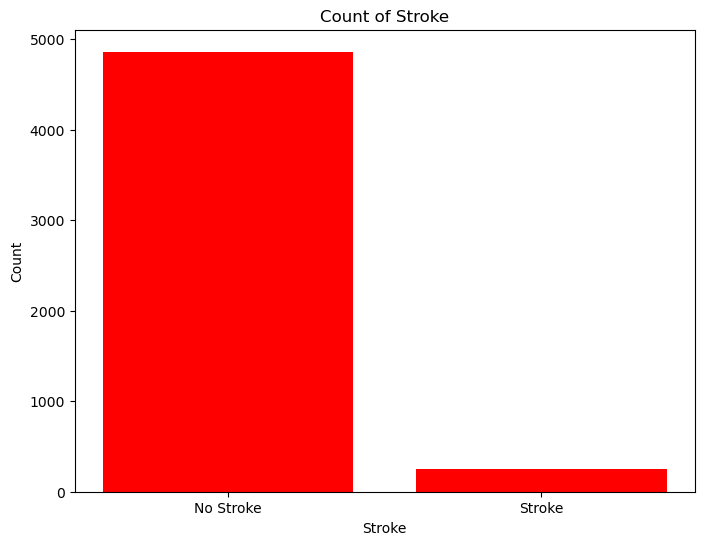

In [10]:
import matplotlib.pyplot as plt

stroke_counts = data['stroke'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(stroke_counts.index, stroke_counts.values, color='red')

plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Count of Stroke')

plt.xticks([0, 1], ['No Stroke', 'Stroke'])

plt.show()

In [11]:
from sklearn.model_selection import train_test_split

X = data[['heart_disease', 'hypertension', 'avg_glucose_level', 'age']].values
y = data[ 'stroke'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
X_train

array([[  0.  ,   0.  , 112.16,  56.  ],
       [  0.  ,   0.  , 107.18,  11.  ],
       [  0.  ,   0.  , 114.92,  48.  ],
       ...,
       [  0.  ,   0.  , 105.08,  30.  ],
       [  0.  ,   0.  ,  89.18,  50.  ],
       [  0.  ,   0.  , 119.52,  40.  ]])

In [14]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
import pandas as pd

column_names = ['heart_disease', 'hypertension', 'avg_glucose_level', 'age']

X_train_with_columns = pd.DataFrame(X_train, columns=column_names)

df_training_data = pd.concat([X_train_with_columns, pd.DataFrame(y_train, columns=['stroke'])], axis=1)

df_training_data

,heart_disease,hypertension,avg_glucose_level,age,stroke
0,0.0,0.0,112.16,56.0,0
1,0.0,0.0,107.18,11.0,0
2,0.0,0.0,114.92,48.0,0
3,0.0,0.0,216.40,79.0,0
4,0.0,0.0,100.16,43.0,0
...,...,...,...,...,...
3572,0.0,0.0,84.48,33.0,0
3573,0.0,0.0,110.68,42.0,0
3574,0.0,0.0,105.08,30.0,0
3575,0.0,0.0,89.18,50.0,0


In [19]:
df_training_data.to_csv('stroke-training_data.csv', header=False, index=False)

In [20]:
s3_bucket = 'lab7-sagemaker-model'
prefix = 'linearlearner'

In [21]:
!aws s3 cp stroke-training_data.csv s3://{s3_bucket}/{prefix}/input/stroke-training_data.csv

upload: ./stroke-training_data.csv to s3://lab7-sagemaker-model/linearlearner/input/stroke-training_data.csv


In [33]:
import sagemaker 
import boto3
from sagemaker import get_execution_role 

role = get_execution_role()
session = sagemaker.Session()
region_name = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [34]:
training_s3_input_location = f"s3://{s3_bucket}/{prefix}/input/stroke-training_data.csv" 
training_s3_output_location = f"s3://{s3_bucket}/{prefix}/output/"

In [47]:
from sagemaker.inputs import TrainingInput

train = TrainingInput(training_s3_input_location, content_type="text/csv")

In [48]:
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", region_name, "1.7-1")
container

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [49]:
estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path=training_s3_output_location,
    sagemaker_session=session)

In [50]:
estimator.set_hyperparameters(predictor_type='regressor', mini_batch_size=4)

In [51]:
estimator.fit({'train': train})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-10-16-18-05-25-224


2023-10-16 18:05:25 Starting - Starting the training job...
2023-10-16 18:05:42 Starting - Preparing the instances for training......
2023-10-16 18:06:43 Downloading - Downloading input data...
2023-10-16 18:07:13 Training - Downloading the training image......
2023-10-16 18:08:04 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/16/2023 18:08:13 INFO 139716728076096] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'a

In [52]:
estimator.__dict__

{'image_uri': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
 '_hyperparameters': {'predictor_type': 'regressor', 'mini_batch_size': 4},
 'instance_count': 1,
 'instance_type': 'ml.m5.xlarge',
 'keep_alive_period_in_seconds': None,
 'instance_groups': None,
 'volume_size': 30,
 'max_run': 86400,
 'input_mode': 'File',
 'metric_definitions': None,
 'model_uri': None,
 'model_channel_name': 'model',
 'code_uri': None,
 'code_channel_name': 'code',
 'source_dir': None,
 'git_config': None,
 'container_log_level': 20,
 'code_location': None,
 'entry_point': None,
 'dependencies': [],
 'uploaded_code': None,
 'tags': None,
 'sagemaker_session': <sagemaker.session.Session at 0x7f1309732a40>,
 'base_job_name': 'linear-learner',
 '_current_job_name': 'linear-learner-2023-10-16-18-05-25-224',
 'output_path': 's3://lab7-sagemaker-model/linearlearner/output/',
 'latest_training_job': <sagemaker.estimator._TrainingJob at 0x7f13090eeb60>,
 'jobs': [<sagemaker.estimator._TrainingJo